# 2D Elastic displacement (mixed formulation)

## Problem description

Consider a beam of thickness $H$ loaded with some force $f = f(x, y)$. Let $\eta = \eta(x, y)$ represent the vertical deflection of the beam in response to $f$, with $\mathbf{M} = \mathbf{M}(x, y)$ the associated bending moment. Define $\lambda_1 := \frac{E}{12(1 + \mu)}$ and $\lambda_2 = \frac{E\mu}{12(1 - \mu^2)}$, where $E$ is Young's Modulus and $\mu$ is Poisson's Ratio. Then the governing equation and constitutive relation on the plate are:

$$
-\nabla\cdot(\nabla\cdot\mathbf{M}) = f
$$

$$
\mathbf{M} = -H^3\lambda_1\nabla\nabla\eta - H^3\lambda_2tr\left(\nabla\nabla\eta\right)\mathbf{I}.
$$ 

Let $n = n(x, y)$ and $\mathbf{N} = \mathbf{N}(x, y)$ be arbitrary scalar and tensor functions. It can be derived that the corresponding weak forms for these equations are:

$$
\int_{\Omega}[(\nabla\cdot\mathbf{M})\cdot\nabla n] - \int_{\Gamma}[n(\nabla\cdot\mathbf{M})\cdot\hat{n}] = \int_{\Omega}nf
$$

$$
\int_\Omega\mathbf{M}:\mathbf{N} = \int_\Omega\nabla\eta\cdot(\nabla\cdot H^3(\lambda_1\mathbf{N} + \lambda_2tr(\mathbf{N})\mathbf{I})) - \int_\Gamma \nabla\eta\cdot H^3(\lambda_1\mathbf{N} + \lambda_2tr(\mathbf{N})\mathbf{I})\cdot\hat{n}
$$

Consequently, define

$$ 
a := \int_{\Omega}[(\nabla\cdot\mathbf{M})\cdot\nabla n] + \int_\Omega\mathbf{M}:\mathbf{N} - \int_\Omega\nabla\eta\cdot(\nabla\cdot H^3(\lambda_1\mathbf{N} + \lambda_2tr(\mathbf{N})\mathbf{I})) - \int_{\Gamma}[n(\nabla\cdot\mathbf{M})\cdot\hat{n}] + \int_\Gamma \nabla\eta\cdot H^3(\lambda_1\mathbf{N} + \lambda_2tr(\mathbf{N})\mathbf{I})\cdot\hat{n}
$$

$$
L := \int_xnf.
$$


The task is now to find $(\mathbf{M}, \eta)$ such that $a = L$ for every $(n, \mathbf{N})$. 

## Imports

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

## Meshing and material parameters

In [2]:
nx, ny = 100, 1 #number of nodes in x, y
Lx, Ly = 10, 10 #length, width of mesh in meters
H = 2 #thickness of the bar in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)

Q1 = FunctionSpace(mesh, 'CG', 2) #this will be η's function space
Q2 = TensorFunctionSpace(mesh, 'CG', 2) #and M's function space
Q = Q1*Q2 #mixed function space for (η, M)

η, M = TrialFunctions(Q) #deflection η, moment M
n, N = TestFunctions(Q)

x, y = SpatialCoordinate(mesh)

ρ_i = 917 #density of ice (kg/m^3)
g = 9.81 #gravitational constant (N/kg)
E = 1e9 #Young's Modulus (Pa)
μ = 1/3 #Poisson's Ratio
λ_1 = E/(12*(1 + μ))
λ_2 = E*μ/(12*(1 - μ**2))

α = 1e10

## Set up and solve the problem

We'll consider a bar with zero displacement and zero bending moment at both ends, so that $\eta = 0$ and $\mathbf{M} = \mathbf{0}$ on boundaries 1 and 2. For the purposes of comparison with an analytic solution, we will make the problem 1D-like by requiring that $M_{xy} = M_{yx} = M_{yy} = 0$ everywhere.

In [3]:
a = dot(div(M), grad(n))*dx + inner(M, N)*dx - dot(grad(η), div(H**3*(λ_1*N + λ_2*tr(N)*Identity(2))))*dx
L = (-ρ_i*g*H*n)*dx

bc_η = DirichletBC(Q.sub(0), Constant(0), (1, 2)) #η = 0 on the left and right boundaries
bc_M = DirichletBC(Q.sub(1), 0*Identity(2), (1, 2)) #M = 0 on the left and right boundaries
a += 1/2*α**2*N[0, 1]*M[0, 1]*dx #M_xy = 0 everywhere on Ω
a += 1/2*α**2*N[1, 0]*M[1, 0]*dx #M_yx = 0 everywhere on Ω
a += 1/2*α**2*N[1, 1]*M[1, 1]*dx #M_yy = 0 everywhere on Ω



q = Function(Q) # q = (η, M_xx, M_xy, M_yx, M_yy)
solve(a == L, q, bcs = [bc_η, bc_M])

## Plot, and compare with the analytic solution

The analytic solutions for the deflection and the bending moment are 

$$
\eta = -\frac{\rho_ig(1 - \mu^2)}{H^2E}\left(\frac{1}{2}x^4 - Lx^3 + \frac{1}{2}L^3x\right)
$$

$$
M = \frac{1}{2}\rho_igH(x^2 - Lx)
$$

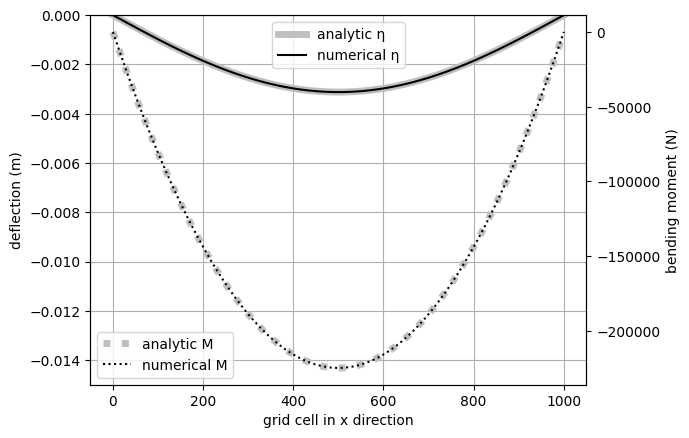

In [4]:
X_ = np.arange(0, Lx + 1/nx, 1/nx)
X = np.array([(k, Ly/2) for k in X_])

analytic_η_profile = -ρ_i*g*(1 - μ**2)/(H**2*E)*(1/2*X_**4 - Lx*X_**3 + 1/2*Lx**3*X_)
analytic_M_profile = 1/2*ρ_i*g*H*(X_**2 - Lx*X_)

modeled_η_profile = Function(Q1).project(q[0]).at(X, tolerance = 1e-10)
modeled_M_profile = Function(Q1).project(q[1]).at(X, tolerance = 1e-10)

plt.figure()
plt.plot(analytic_η_profile, color = '0.75', linewidth = 5, label = 'analytic η')
plt.plot(modeled_η_profile, color = 'k', linestyle = 'solid', label = 'numerical η')
plt.legend(loc = 'upper center')
plt.ylim(-0.015, 0)
plt.xlabel('grid cell in x direction')
plt.ylabel('deflection (m)')
plt.grid()
plt.twinx()
plt.plot(analytic_M_profile, color = '0.75', linewidth = 5, linestyle = 'dotted', label = 'analytic M')
plt.plot(modeled_M_profile, color = 'k', linestyle = 'dotted', label = 'numerical M')
plt.ylabel('bending moment (N)')
plt.legend(loc = 'lower left')